In [115]:
import cv2
import numpy as np
from part_detection import detect_bow, detect_fingerboard, detect_both
import time
import pandas as pd
import pickle

In [2]:
# find the number of files in both directories
from os import listdir
from os.path import isfile, join
mypath = './cello_pics'
pics = [f for f in listdir(mypath) if isfile(join(mypath, f))]
mypath_detected = './cello_pics_detected'
pics_detected = [f for f in listdir(mypath_detected) if isfile(join(mypath_detected, f))]
print(len(pics))
print(len(pics_detected))

132
135


In [4]:
# create detected versions in separate folder for labelling purposes
for pic in pics:
    if pic in pics_detected:
        continue
    img = cv2.imread('./cello_pics/' + pic)
    height, width, _ = img.shape
    temp = cv2.resize(img, (width//2, height//2))
    detected = detect_both(temp, optimized = False)[0]
    cv2.imwrite('./cello_pics_detected/' + pic, detected)

In [124]:
# generate theta features for each image
cellos = pd.read_csv('cello_string_labels.csv')
cellos_worked = cellos[cellos['worked'] == 1]
t1 = []
t2 = []
for cello in cellos_worked['image_name']:
    try:
        img = cv2.imread('./cello_pics/' + cello + '.jpg')
        height, width, _ = img.shape
        temp = cv2.resize(img, (width//2, height//2))
        detected = detect_both(temp, optimized = False)
        t1.append(detected[3])
        t2.append((detected[4] + np.pi/2) % (np.pi))
    except:
        print(cello, 'not found')
cellos_worked['theta1'] = t1
cellos_worked['theta2'] = t2
cellos_worked.to_csv('strings_with_thetas.csv', index = False)

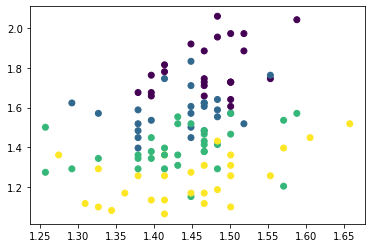

In [5]:
# plot thetas with color
import matplotlib.pyplot as plt

plt.scatter(cellos_worked['theta1'], cellos_worked['theta2'], c = cellos_worked['string'])
plt.show()

In [94]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

train, test = train_test_split(cellos_worked, test_size=0.2)

In [95]:
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(train[['theta1', 'theta2']], train['string'])

print((neigh.predict(test[['theta1', 'theta2']]) == test['string']).mean())

0.8636363636363636


<ipython-input-114-22cac271b4a3>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
<ipython-input-114-22cac271b4a3>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


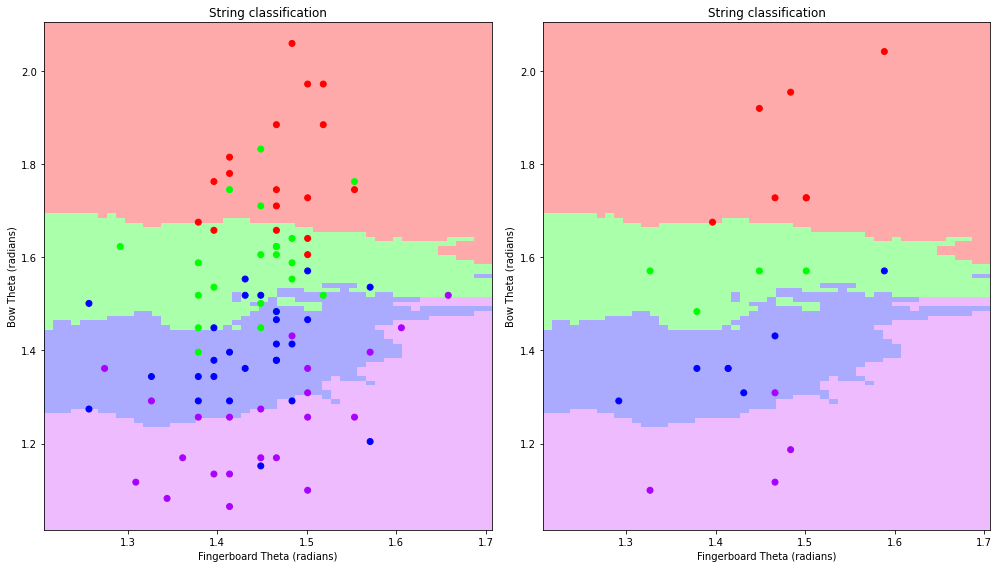

In [114]:
# credit: https://stackoverflow.com/questions/45075638/graph-k-nn-decision-boundaries-in-matplotlib
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets


# create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#EEBBFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#AA00FF'])

# create grid using meshgrid
h = .01
x_min, x_max = cellos_worked['theta1'].min() - 0.05, cellos_worked['theta1'].max() + 0.05
y_min, y_max = cellos_worked['theta2'].min() - 0.05, cellos_worked['theta2'].max() + 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = neigh.predict(np.c_[xx.ravel(), yy.ravel()])

fig, ax = plt.subplots(2, 2, figsize = (14, 8))

# plot boundaries
plt.subplot(1,2,1)
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# also plot train points
plt.scatter(train['theta1'], train['theta2'], c=train['string'], cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("String classification")
plt.xlabel('Fingerboard Theta (radians)')
plt.ylabel('Bow Theta (radians)')

# plot boundaries
plt.subplot(1,2,2)
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# also plot test points
plt.scatter(test['theta1'], test['theta2'], c=test['string'], cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("String classification")
plt.xlabel('Fingerboard Theta (radians)')
plt.ylabel('Bow Theta (radians)')

plt.tight_layout()
plt.show()

In [116]:
# save knn model
filename = 'string_predict_knn.sav'
pickle.dump(neigh, open(filename, 'wb'))

In [123]:
# load knn model
loaded_model = pickle.load(open('string_predict_knn.sav', 'rb'))
loaded_model.predict(test[['theta1', 'theta2']])
loaded_model.score(test[['theta1', 'theta2']], test['string'])

0.8636363636363636

## LOO CV

{1: 0.512, 2: 0.605, 3: 0.581, 4: 0.628, 5: 0.628, 6: 0.651, 7: 0.663, 8: 0.674, 9: 0.64, 10: 0.686, 11: 0.698, 12: 0.686, 13: 0.674, 14: 0.663, 15: 0.64}


Text(0, 0.5, 'Cross Validation Accuracy')

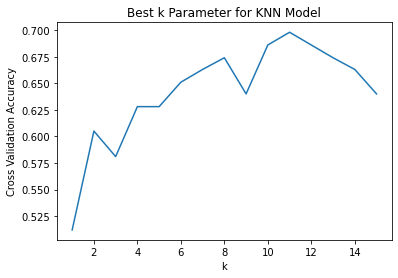

In [188]:
from sklearn.model_selection import LeaveOneOut


loo = LeaveOneOut()

corrects = dict()
count = 0
for i in range(1):
    train2, test2 = train_test_split(cellos_worked, test_size=0.2)
    for k in range(1, 16):
        neigh = KNeighborsClassifier(n_neighbors = k)
        correct = 0
        for train_index, test_index in loo.split(train):
            X_train = train2.iloc[train_index]
            X_test = train2.iloc[test_index]
            neigh.fit(X_train[['theta1', 'theta2']], X_train['string'])
            correct += int(neigh.predict(X_test[['theta1', 'theta2']]) == X_test['string'])
            count += 1
        corrects[k] = corrects.get(k, 0) + correct
count = count / 15
for k in range(1, 16):
    corrects[k] = round(corrects.get(k, 0) / count, 3)

print(corrects)

x = range(1, 16)
y = [item[1] for item in corrects.values()]
plt.plot(x, y)
plt.title('Best k Parameter for KNN Model')
plt.xlabel('k')
plt.ylabel('Cross Validation Accuracy')

In [202]:
# d = {'accuracy': corrects.values()}
pd.DataFrame(data = {'validation accuracy': corrects.values()}, index = range(1, 16))
# corrects.values()

,validation accuracy
1,0.512
2,0.605
3,0.581
4,0.628
5,0.628
6,0.651
7,0.663
8,0.674
9,0.640
10,0.686


In [177]:
train3, test3 = train_test_split(cellos_worked, test_size=0.2)

In [178]:
neigh = KNeighborsClassifier(n_neighbors=12)
neigh.fit(train3[['theta1', 'theta2']], train3['string'])

print((neigh.predict(test3[['theta1', 'theta2']]) == test3['string']).mean())

0.7272727272727273


<ipython-input-186-94b2818af39b>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
<ipython-input-186-94b2818af39b>:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


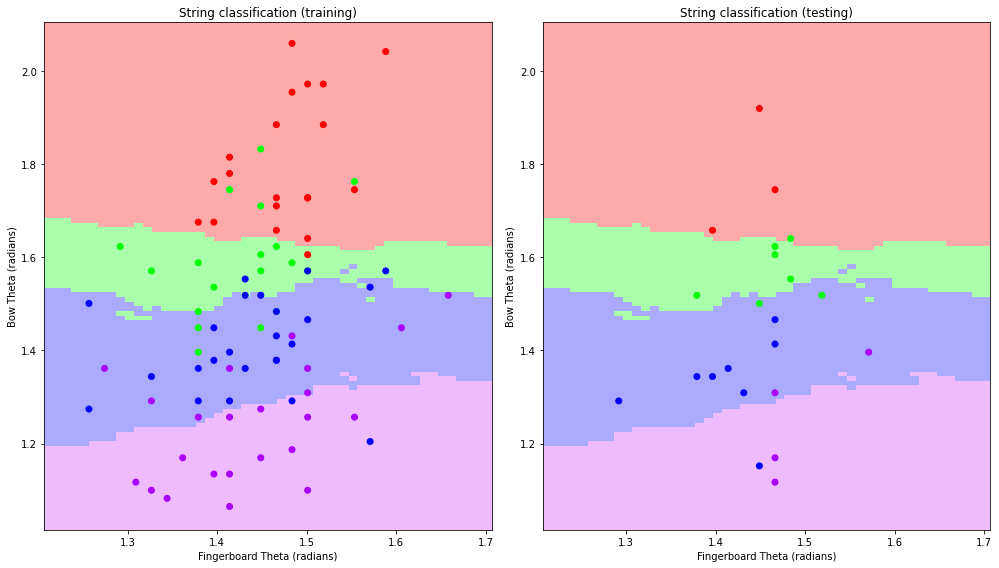

In [186]:
# credit: https://stackoverflow.com/questions/45075638/graph-k-nn-decision-boundaries-in-matplotlib

# create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#EEBBFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#AA00FF'])

# create grid using meshgrid
h = .01
x_min, x_max = cellos_worked['theta1'].min() - 0.05, cellos_worked['theta1'].max() + 0.05
y_min, y_max = cellos_worked['theta2'].min() - 0.05, cellos_worked['theta2'].max() + 0.05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = neigh.predict(np.c_[xx.ravel(), yy.ravel()])

fig, ax = plt.subplots(2, 2, figsize = (14, 8))

# plot boundaries
plt.subplot(1,2,1)
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# also plot train points
plt.scatter(train3['theta1'], train3['theta2'], c=train3['string'], cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("String classification (training)")
plt.xlabel('Fingerboard Theta (radians)')
plt.ylabel('Bow Theta (radians)')

# plot boundaries
plt.subplot(1,2,2)
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# also plot test points
plt.scatter(test3['theta1'], test3['theta2'], c=test3['string'], cmap=cmap_bold)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("String classification (testing)")
plt.xlabel('Fingerboard Theta (radians)')
plt.ylabel('Bow Theta (radians)')

plt.tight_layout()
plt.show()